In [1]:
import wecopttool as wot
import autograd.numpy as np
from xarray import DataArray
import matplotlib.pyplot as plt


In [2]:
from wecopttool.waves import jonswap_spectrum as js
from wecopttool.waves import long_crested_wave as lcw
from wecopttool.waves import omnidirectional_spectrum

#goal: get elevation provile at different spatial coordinates around a WEC for example for simulation....
Would need phase shift of all components?!

In [3]:
res = 7 #ensure good resolution of spectrumca
harm = 5 #get n harmonics in dynamics
fp = 0.1

f1 = fp/res
nfreq = res*harm
Hm0 = 0.5
gamma = 10
dir = 0
ndir = 1
nrel = 1
w_seed = 42

omnidir_spectrum = omnidirectional_spectrum(f1, nfreq,
                            spectrum_func=lambda f: js(freq=f, fp=fp, hs=Hm0, gamma=gamma),
                            spectrum_name="JONSWAP",)
                            
waves = lcw(omnidir_spectrum, nrealizations = nrel, direction = dir, seed = w_seed) #added seed for repeatable phase, should matter for low nr frequencies, since only short time series is considered


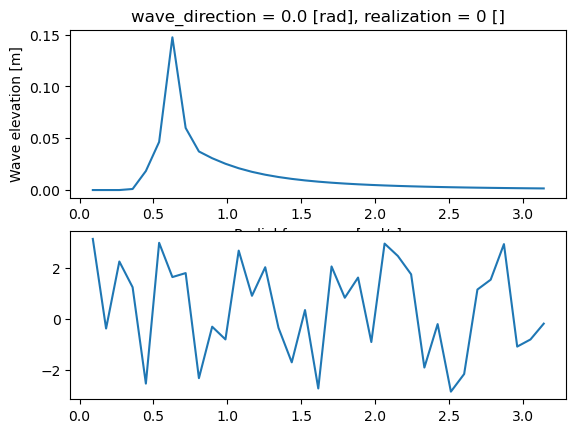

In [4]:
fig, axes = plt.subplots(2,1)
np.abs(waves).plot(ax = axes[0])
axes[1].plot(waves.omega, np.angle(waves).squeeze())

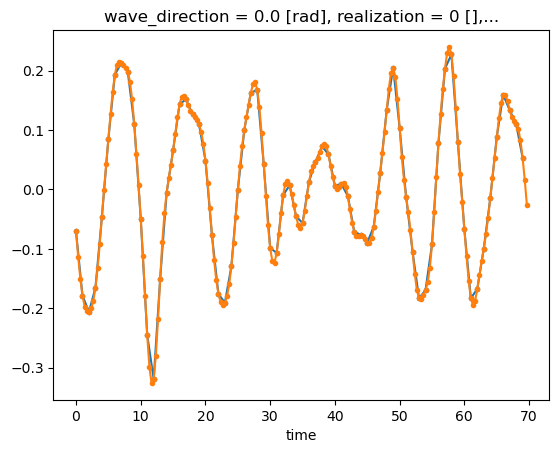

In [5]:

for nsub in [1, 3]:
    t_dat = wot.time(f1, nfreq, nsubsteps= nsub)
    time = DataArray(
                    data=t_dat, name='time', dims='time', coords=[t_dat])
    wave_td = wot.time_results(waves, time)
    wave_td.plot(marker = '.')

#manual wave to better understand the phase shifting

In [6]:
from typing import Iterable, Callable, Any, Optional, Mapping, TypeVar, Union
from numpy.typing import ArrayLike
from autograd.numpy import ndarray

FloatOrArray = Union[float, ArrayLike]

def radians_to_degrees(
    radians: FloatOrArray,
    sort: Optional[bool] = True,
) -> Union[float, ndarray]:
    """Convert a 1D array of angles in radians to degrees in the range
    :math:`[-180, 180)` and optionally sort them.

    Parameters
    ----------
    radians
        1D array of angles in radians.
    sort
        Whether to sort the angles from smallest to largest in
        :math:`[-180, 180)`.
    """
    degrees = np.asarray(np.remainder(np.rad2deg(radians), 360))
    degrees[degrees > 180] -= 360
    if degrees.size > 1 and sort:
        degrees = np.sort(degrees)
    return degrees

In [7]:
df = f1
values = omnidir_spectrum.values
values[values<0] = np.nan
amplitudes = np.sqrt(2 * values * df)

r_phase = wot.waves.random_phase(shape = [nfreq, ndir, nrel], seed = w_seed)
# camplitude = amplitudes * np.exp(1j*r_phase)
wave_celerity = 9.81/waves.omega
waves_length = 9.81*(1/waves.freq)**2/(2*np.pi)
wave_number = 2*np.pi/waves_length
manual_wave = wot.waves.elevation_fd(f1, nfreq, 
                        directions=dir, 
                        nrealizations=nrel, 
                        amplitudes=amplitudes, 
                        phases=np.rad2deg(r_phase - np.expand_dims(wave_number*1,axis=(1, 2))))

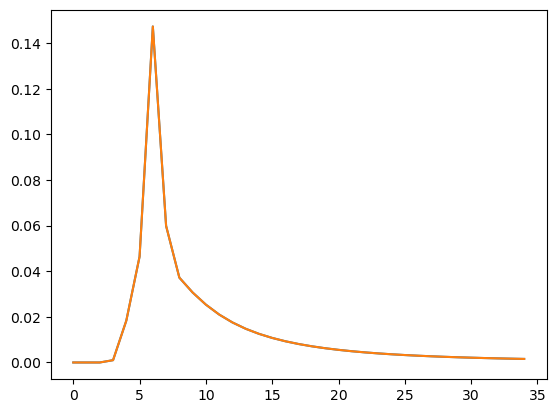

In [17]:
plt.plot(amplitudes)
plt.plot(np.abs(waves.squeeze()))

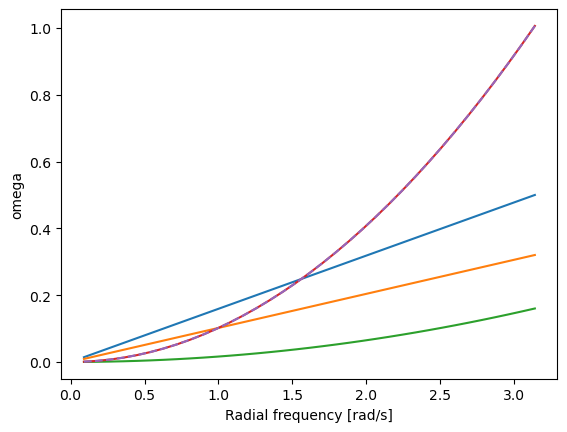

In [9]:
(wave_celerity/waves_length).plot()
(1/wave_celerity).plot()
(1/waves_length).plot()
wave_number.plot()
(waves.omega**2/9.81).plot(linestyle = '--')

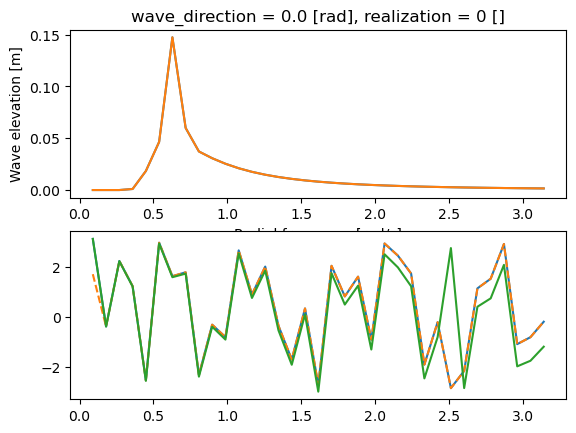

In [10]:
fig, axes = plt.subplots(2,1)
np.abs(manual_wave).plot(ax = axes[0])
np.abs(waves).plot(ax = axes[0])
axes[1].plot(waves.omega, np.angle(waves).squeeze())
axes[1].plot(manual_wave.omega, np.squeeze(r_phase), linestyle = '--')
axes[1].plot(manual_wave.omega, np.angle(manual_wave).squeeze())

In [ ]:
for wave in [waves, manual_wave]:
    t_dat = wot.time(f1, nfreq, nsubsteps= 1)
    time = DataArray(
                    data=t_dat, name='time', dims='time', coords=[t_dat])
    wave_td = wot.time_results(wave, time)
    wave_td.plot(marker = '.')

In [ ]:
spatial_vec = np.linspace(-1,1,25)
fig, axes = plt.subplots(1, 1, subplot_kw={'projection': '3d'}) 
t_dat = wot.time(f1, nfreq, nsubsteps= 1)
time = DataArray(
                data=t_dat, name='time', dims='time', coords=[t_dat])
for x in spatial_vec:
    # print(x)
    manual_wave = wot.waves.elevation_fd(f1, nfreq, 
                            directions=dir, 
                            nrealizations=nrel, 
                            amplitudes=amplitudes, 
                            phases=radians_to_degrees(r_phase - np.expand_dims(x*wave_number,axis=(1, 2))))

    wave_td = wot.time_results(manual_wave, time)
    for tind in [0, 1, 2, 3, 5]:
        axes.plot(x, time[tind], wave_td[0,0,tind], marker = 'o')

In [ ]:
# Define spatial and temporal vectors
spatial_vec = np.linspace(-10, 10, 25)
t_dat = wot.time(f1, nfreq, nsubsteps=1)
time = DataArray(data=t_dat, name='time', dims='time', coords=[t_dat])

# Create a meshgrid for spatial coordinates and time
t_end = 10
X, T = np.meshgrid(spatial_vec, time[0:t_end])

# Initialize a matrix to hold wave elevations
wave_elevations = np.zeros(X.shape)

# Calculate wave elevations for each combination of x and time
for i, x in enumerate(spatial_vec):
    manual_wave = wot.waves.elevation_fd(f1, nfreq, 
                                          directions=dir, 
                                          nrealizations=nrel, 
                                          amplitudes=amplitudes, 
                                          phases=radians_to_degrees(r_phase - np.expand_dims( x*wave_number, axis=(1, 2))))
    
    wave_td = wot.time_results(manual_wave, time)
    
    # Store the wave elevations for the current spatial coordinate across all time indices
    wave_elevations[:, i] = wave_td[0, 0, 0:t_end]

# Create a 3D plot
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

# Plot the surface
axes.plot_surface(X, T, wave_elevations, cmap='viridis')

# Set labels
axes.set_xlabel('Spatial Coordinate (x)')
axes.set_ylabel('Time')
axes.set_zlabel('Wave Elevation')

axes.set_zlim([-1, 1])
# Show the plot
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
# Define spatial and temporal vectors
spatial_vec = np.linspace(-10, 10, 20)
t_dat = wot.time(f1, nfreq, nsubsteps=2)
time = DataArray(data=t_dat, name='time', dims='time', coords=[t_dat])

# Initialize a matrix to hold wave elevations
wave_elevations = np.zeros((len(spatial_vec), len(time)))

# Calculate wave elevations for each combination of x and time
for i, x in enumerate(spatial_vec):
    manual_wave = wot.waves.elevation_fd(f1, nfreq, 
                                          directions=dir, 
                                          nrealizations=nrel, 
                                          amplitudes=amplitudes, 
                                          phases=radians_to_degrees(r_phase -np.expand_dims( x*wave_number, axis=(1, 2))))
    
    wave_td = wot.time_results(manual_wave, time)
    
    # Store the wave elevations for the current spatial coordinate across all time indices
    wave_elevations[i, :] = wave_td[0, 0, :]

# Create a figure for the animation
fig, ax = plt.subplots()
line, = ax.plot(spatial_vec, wave_elevations[:, 0], color='b')
ax.set_xlim(-5, 5)
ax.set_ylim(-1, 1)

# ax.set_ylim(np.min(wave_elevations), np.max(wave_elevations))
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('Spatial Coordinate (x)')
ax.set_ylabel('Wave Elevation')
ax.set_title('Wave Elevation Over Time')

# Animation update function
def update(frame):
    line.set_ydata(wave_elevations[:, frame])  # Update the y data for the current frame
    ax.set_title(f'Wave Elevation at Time = {time[frame]:.2f}')  # Update the title with the current time
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(time), blit=True, interval=2*len(time))
ani

In [ ]:
%matplotlib inline
plt.rcParams["animation.html"] = "none"
plt.show()
plt.plot(np.squeeze(np.rad2deg(np.expand_dims(wave_celerity * 1, axis=(1, 2)))))

## regular waves

In [ ]:
reg_waves = wot.waves.regular_wave(f1, nfreq, freq = 0.1, amplitude=0.3, phase=0.0)

In [ ]:
from matplotlib.animation import FuncAnimation
plt.rcParams["animation.html"] = "jshtml"
plt.ioff()
# Define spatial and temporal vectors
spatial_vec = np.linspace(-10, 10, 20)
t_dat = wot.time(f1, nfreq, nsubsteps=1)
time = DataArray(data=t_dat, name='time', dims='time', coords=[t_dat])

# Initialize a matrix to hold wave elevations
wave_elevations = np.zeros((len(spatial_vec), len(time)))
reg_wave_freq = 0.1
reg_wave_celerity = 9.81/(2*np.pi*reg_wave_freq)
reg_wave_length =  9.81*(1/reg_wave_freq)**2/(2*np.pi)
reg_wave_number = (2*np.pi)/reg_wave_length
# Calculate wave elevations for each combination of x and time
for i, x in enumerate(spatial_vec):
    manual_wave = wot.waves.regular_wave(f1, nfreq, freq = 0.1, amplitude=0.3, phase= np.rad2deg(-1 * x*reg_wave_number))
    
    wave_td = wot.time_results(manual_wave, time)
    
    # Store the wave elevations for the current spatial coordinate across all time indices
    wave_elevations[i, :] = wave_td[0, 0, :]

# Create a figure for the animation
fig, ax = plt.subplots()
line, = ax.plot(spatial_vec, wave_elevations[:, 0], color='b')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('Spatial Coordinate (x)')
ax.set_ylabel('Wave Elevation')
ax.set_title('Wave Elevation Over Time')

# Animation update function
def update(frame):
    line.set_ydata(wave_elevations[:, frame])  # Update the y data for the current frame
    ax.set_title(f'Wave Elevation at Time = {time[frame]:.2f}')  # Update the title with the current time
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=len(time), blit=True, interval=200)
ani

In [ ]:
reg_wave_number

In [ ]:
wave_td